In [1]:
# ---- Reproducibility
import random
import torch

seed = 1234
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


In [2]:


# ---- Parameters
n, p = 50, 40
noise_std = 0.1

# (Optional) choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Data generation (PyTorch)
# Use float64 to mirror NumPy defaults
u = torch.rand(n, dtype=torch.float64, device=device)          # length n
v = torch.rand(p, dtype=torch.float64, device=device)          # length p

# Rank-1 matrix via outer product
rank_1_matrix = torch.outer(u, v)                              # (n, p)

# Homoscedastic Gaussian noise
noise = noise_std * torch.randn(n, p, dtype=torch.float64, device=device)

noisy_matrix = rank_1_matrix + noise

# ---- Print (move to CPU for readability if needed)
print("Rank-1 Matrix (Outer Product):")
print(rank_1_matrix.cpu().numpy())

print("\nNoisy Matrix (with Homoscedastic Noise):")
print(noisy_matrix.cpu().numpy())


Rank-1 Matrix (Outer Product):
[[0.0369924  0.12349849 0.01266485 ... 0.20919041 0.20178125 0.15269329]
 [0.01256629 0.04195233 0.00430224 ... 0.0710618  0.06854491 0.05186978]
 [0.07442166 0.24845541 0.02547927 ... 0.42085123 0.40594542 0.3071898 ]
 ...
 [0.13003676 0.43412546 0.04451985 ... 0.73535219 0.70930731 0.53675188]
 [0.02568535 0.08575008 0.00879373 ... 0.14524951 0.14010503 0.10602124]
 [0.01213768 0.04052142 0.0041555  ... 0.06863803 0.06620699 0.05010061]]

Noisy Matrix (with Homoscedastic Noise):
[[ 0.14788041  0.16955928  0.1824038  ...  0.06284919  0.26615598
   0.04153663]
 [-0.07975735  0.07738678 -0.06536086 ...  0.08710195  0.01799688
   0.10035783]
 [ 0.15693369  0.13496091 -0.12057474 ...  0.40187727  0.53974668
   0.3314774 ]
 ...
 [ 0.16086152  0.64130937  0.12866035 ...  0.67670073  0.59595961
   0.57849158]
 [-0.06675871 -0.03323521 -0.03429034 ...  0.1487228   0.2078188
   0.18898802]
 [-0.14480705  0.07884231  0.03359961 ... -0.16932926  0.1779711
   0.1486

In [3]:
import sys
import os
import matplotlib.pyplot as plt
from cebmf_torch import cEBMF

In [4]:
mycebmf=  cEBMF(data= noisy_matrix,
                prior_L="point_laplace",
                  prior_F="point_laplace") 

In [5]:
mycebmf.initialize()
print(mycebmf.L[:,1])
print(mycebmf.F[:,1])

tensor([ 0.0080, -0.1905,  0.2605, -0.2120,  0.2116,  0.1896, -0.2458, -0.2640,
         0.1057,  0.1225,  0.0676,  0.0620, -0.0016,  0.1750,  0.1087, -0.0761,
         0.1078, -0.4832,  0.0641,  0.1960, -0.2287, -0.0704, -0.2441,  0.0377,
        -0.2611, -0.1291,  0.3901, -0.0387, -0.1331, -0.2875, -0.2095,  0.1439,
        -0.0307, -0.0648,  0.0598, -0.0430,  0.1896,  0.1109,  0.0643, -0.0023,
        -0.0328, -0.2137,  0.0720,  0.0039, -0.1591, -0.2714, -0.0136,  0.1367,
         0.0542,  0.2452])
tensor([ 0.0610,  0.0381, -0.0373,  0.1844, -0.0388, -0.1764,  0.0488, -0.3281,
        -0.0793,  0.0009,  0.2299,  0.1970,  0.0735, -0.2066,  0.0725, -0.2878,
        -0.0727,  0.3067, -0.2505,  0.0539,  0.1928,  0.0201, -0.0158,  0.1157,
         0.1509,  0.0815,  0.0377,  0.1380,  0.1188, -0.1703, -0.0225, -0.0766,
        -0.2759,  0.2154,  0.2396, -0.1764, -0.0045, -0.1609,  0.1603,  0.0669])


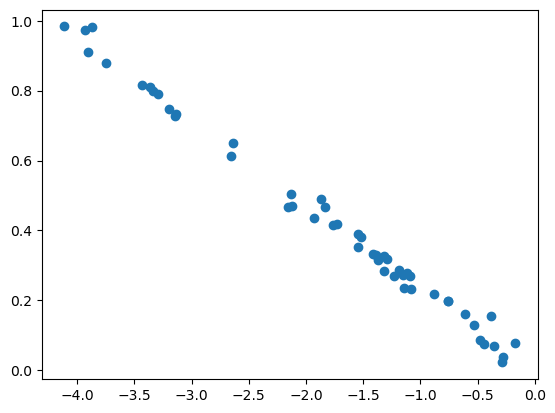

In [6]:
plt.scatter( mycebmf.L[:,0],u)

In [7]:
mycebmf.initialize () 
tau_map=None
eps=1e-12

In [8]:
for k in range (mycebmf.K):
# ---------- Update L[:, k] ----------
        Rk = mycebmf._partial_residual_masked(k)            # (N,P), zeros where missing
        fk  = mycebmf.F[:, k]                                # (P,)
        fk2 = mycebmf.F2[:, k]                               # (P,)

        if tau_map is None:
            denom_l = (fk2.view(1, -1) * mycebmf.mask).sum(dim=1).clamp_min(eps)     # (N,)
            num_l   = (Rk @ fk)                                                   # (N,)
            se_l    = torch.sqrt(1.0 / (mycebmf.tau * denom_l))
        else:
            denom_l = (tau_map * (fk2.view(1, -1) * mycebmf.mask)).sum(dim=1).clamp_min(eps)  # (N,)
            num_l   = (tau_map * Rk) @ fk                                                 # (N,)
            se_l    = torch.sqrt(1.0 / denom_l)

        lhat = num_l / denom_l
       # print(denom_l)
        resL = mycebmf.prior_L_fn(
            X=getattr(mycebmf, "X_l", None),
            betahat=lhat,
            sebetahat=se_l,
            model_param=mycebmf.model_state_L[k]
        )
        mycebmf.model_state_L[k] = resL.model_param
        mycebmf.L[:, k]  = resL.post_mean
        mycebmf.L2[:, k] = resL.post_mean2
        mycebmf.kl_l[k]  = torch.as_tensor(resL.loss, device=mycebmf.device)

    # ---------- Update F[:, k] ----------
        Rk = mycebmf._partial_residual_masked(k)            # recompute with updated L
        lk  = mycebmf.L[:, k]                               # (N,)
        lk2 = mycebmf.L2[:, k]                              # (N,)

        if tau_map is None:
            denom_f = (lk2.view(-1, 1) * mycebmf.mask).sum(dim=0).clamp_min(eps)      # (P,)
            num_f   = (Rk.T @ lk)                                                  # (P,)
            se_f    = torch.sqrt(1.0 / (mycebmf.tau * denom_f))
        else:
            denom_f = (tau_map * (lk2.view(-1, 1) * mycebmf.mask)).sum(dim=0).clamp_min(eps)  # (P,)
            num_f   = (tau_map * Rk).T @ lk                                                # (P,)
            se_f    = torch.sqrt(1.0 / denom_f)

        fhat = num_f / denom_f
        print(denom_f[1])
        resF = mycebmf.prior_F_fn(
            X=getattr(mycebmf, "X_f", None),
            betahat=fhat,
            sebetahat=se_f,
            model_param=mycebmf.model_state_F[k]
        )
        mycebmf.model_state_F[k] = resF.model_param
        mycebmf.F[:, k]  = resF.post_mean
        mycebmf.F2[:, k] = resF.post_mean2
        mycebmf.kl_f[k]  = torch.as_tensor(resF.loss, device=mycebmf.device)
 
print(mycebmf.F)

tensor(226.3677)
tensor(1.1670)
tensor(0.8811)
tensor(0.7962)
tensor(0.7605)
tensor([[-3.4604e-02,  2.4081e-02, -1.7526e-02,  2.7390e-01, -4.0406e-02],
        [-1.4088e-01,  1.8866e-02,  1.9062e-01,  1.2350e-01,  1.5275e-02],
        [-3.3036e-03, -2.4558e-02,  7.2551e-02, -1.4676e-05, -4.4157e-02],
        [-2.0405e-01,  1.5389e-01, -1.1466e-02,  1.1728e-02,  8.2984e-02],
        [-1.1759e-01, -1.1704e-02,  1.2970e-02, -2.0179e-02, -8.7432e-03],
        [-7.1790e-03, -1.4012e-01,  2.8348e-02, -4.4780e-01, -2.6313e-02],
        [-2.3100e-01,  2.0657e-02, -4.2314e-02,  1.6417e-01, -3.5329e-02],
        [-1.7517e-01, -2.9818e-01, -1.1784e-02, -3.4545e-02, -3.4561e-02],
        [-1.5371e-01, -4.0446e-02,  2.2794e-02,  3.3718e-02, -1.5416e-02],
        [-2.2277e-01,  5.2719e-03, -2.1035e-01, -6.3521e-02,  1.8165e-01],
        [-5.4403e-02,  2.0497e-01,  1.2045e-01,  8.5471e-02, -5.9368e-02],
        [-1.9403e-01,  1.6700e-01,  4.4794e-03,  1.5769e-02, -7.4777e-02],
        [-2.6090e-02,  

In [9]:
mycebmf.initialize()

5
tensor([[-3.4604e-02,  2.4081e-02, -1.7526e-02,  2.7390e-01, -4.0406e-02],
        [-1.4088e-01,  1.8866e-02,  1.9062e-01,  1.2350e-01,  1.5275e-02],
        [-3.3036e-03, -2.4558e-02,  7.2551e-02, -1.4676e-05, -4.4157e-02],
        [-2.0405e-01,  1.5389e-01, -1.1466e-02,  1.1728e-02,  8.2984e-02],
        [-1.1759e-01, -1.1704e-02,  1.2970e-02, -2.0179e-02, -8.7432e-03],
        [-7.1790e-03, -1.4012e-01,  2.8348e-02, -4.4780e-01, -2.6313e-02],
        [-2.3100e-01,  2.0657e-02, -4.2314e-02,  1.6417e-01, -3.5329e-02],
        [-1.7517e-01, -2.9818e-01, -1.1784e-02, -3.4545e-02, -3.4561e-02],
        [-1.5371e-01, -4.0446e-02,  2.2794e-02,  3.3718e-02, -1.5416e-02],
        [-2.2277e-01,  5.2719e-03, -2.1035e-01, -6.3521e-02,  1.8165e-01],
        [-5.4403e-02,  2.0497e-01,  1.2045e-01,  8.5471e-02, -5.9368e-02],
        [-1.9403e-01,  1.6700e-01,  4.4794e-03,  1.5769e-02, -7.4777e-02],
        [-2.6090e-02,  3.9915e-02, -1.2739e-01, -1.1076e-01, -7.1105e-02],
        [-1.7114e-01, -

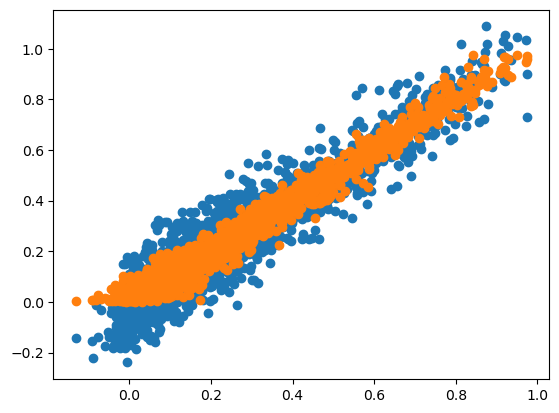

In [10]:
mycebmf.iter_once()  
mycebmf.update_fitted_value()
print(mycebmf.F)
plt.scatter(mycebmf.Y_fit, noisy_matrix)
 
plt.scatter(mycebmf.Y_fit, rank_1_matrix)

In [11]:
mycebmf.L2

tensor([[1.1651e+00, 2.5792e-03, 1.5885e-02, 4.8895e-02, 2.4329e-03],
        [2.9721e-02, 2.2165e-02, 1.3746e-02, 2.1984e-03, 4.4095e-03],
        [4.6407e+00, 5.1209e-02, 6.4024e-02, 2.7600e-03, 2.3566e-03],
        [3.0937e+00, 3.0467e-02, 4.5879e-02, 1.9697e-03, 3.9566e-02],
        [2.3823e+00, 3.2099e-02, 6.9363e-03, 2.7423e-02, 2.9920e-02],
        [1.5141e+00, 2.5020e-02, 6.5227e-03, 2.6856e-03, 2.0855e-03],
        [5.8245e-01, 4.4440e-02, 2.6209e-03, 3.5252e-03, 1.2862e-01],
        [1.3068e+00, 5.2729e-02, 2.2121e-02, 1.6225e-03, 1.9891e-03],
        [1.1879e+00, 7.6975e-03, 2.7964e-03, 4.4826e-02, 8.0316e-03],
        [1.5217e+01, 9.7751e-03, 2.6781e-03, 4.0098e-03, 2.0843e-03],
        [1.1278e+01, 4.3413e-03, 6.2236e-03, 1.7676e-02, 1.7224e-03],
        [8.3949e-02, 4.0915e-03, 1.8192e-02, 8.2415e-03, 7.4476e-02],
        [9.8256e+00, 2.5610e-03, 9.8523e-03, 1.9454e-02, 1.9396e-03],
        [7.0301e+00, 2.0706e-02, 2.1979e-03, 1.8816e-03, 1.9805e-02],
        [1.3237e+00,

In [12]:
mycebmf.update_fitted_value()

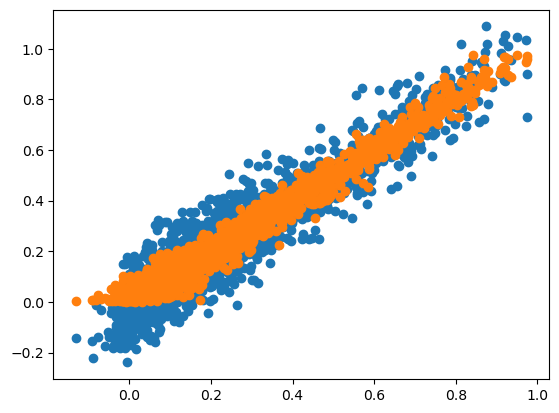

In [13]:
plt.scatter(mycebmf.Y_fit, noisy_matrix)
 
plt.scatter(mycebmf.Y_fit, rank_1_matrix)

In [14]:
from cebmf_torch.torch_main import *
mycebmf=  cEBMF(data= noisy_matrix,
                prior_L="point_laplace",
                  prior_F="point_laplace") 
mycebmf.initialize()
k=0

In [15]:
 

mycebmf.L

tensor([[-1.0800e+00,  8.0196e-03,  1.5701e-01,  2.6303e-01, -4.1739e-02],
        [-1.7109e-01, -1.9046e-01,  1.4650e-01,  3.7131e-02,  8.8875e-02],
        [-2.1563e+00,  2.6045e-01, -2.9440e-01,  5.0543e-02, -4.6051e-02],
        [-1.7606e+00, -2.1199e-01,  2.5109e-01, -1.1951e-02,  2.4847e-01],
        [-1.5449e+00,  2.1157e-01,  9.9516e-02,  2.0594e-01, -2.2076e-01],
        [-1.2314e+00,  1.8960e-01, -1.3784e-01,  5.0737e-02,  2.0818e-02],
        [-7.6256e-01, -2.4581e-01,  2.3146e-03,  7.5396e-02, -4.0319e-01],
        [-1.1439e+00, -2.6397e-01,  1.8187e-01, -8.0567e-02, -8.1205e-03],
        [-1.0905e+00,  1.0566e-01,  2.1918e-02,  2.5164e-01,  1.1956e-01],
        [-3.9036e+00,  1.2250e-01,  1.1006e-02,  8.3848e-02, -1.0205e-01],
        [-3.3608e+00,  6.7632e-02, -1.3782e-01, -1.8388e-01, -7.9343e-02],
        [-2.8256e-01,  6.1964e-02,  1.6782e-01, -1.5000e-01,  3.2100e-01],
        [-3.1371e+00, -1.5682e-03,  1.2186e-01,  1.8391e-01, -6.9569e-02],
        [-2.6537e+00,  1.

In [16]:

k=0
Rk = mycebmf._partial_residual_masked(k)            # (N,P), zeros where missing
fk  = mycebmf.F[:, k]                                # (P,)
fk2 = mycebmf.F2[:, k]                               # (P,)

eps = 1e-12
denom_l = (fk2.view(1, -1) * mycebmf.mask).sum(dim=1).clamp_min(eps)     # (N,)
num_l   = (Rk @ fk)                                                   # (N,)
se_l    = torch.sqrt(1.0 / (mycebmf.tau * denom_l))


lhat = num_l / denom_l

resL = mycebmf.prior_L_fn(
            X=getattr(mycebmf, "X_l", None),
            betahat=lhat,
            sebetahat=se_l,
            model_param=mycebmf.model_state_L[k]
)
mycebmf.model_state_L[k] = resL.model_param
mycebmf.L[:, k]  = resL.post_mean
mycebmf.L2[:, k] = resL.post_mean2
mycebmf.kl_l[k]  = torch.as_tensor(resL.loss, device=mycebmf.device)

In [17]:
se_l
resL.post_mean2

tensor([ 1.1651,  0.0297,  4.6407,  3.0937,  2.3823,  1.5141,  0.5825,  1.3068,
         1.1879, 15.2174, 11.2778,  0.0839,  9.8256,  7.0301,  1.3237,  1.9324,
         1.8846,  0.5742, 10.2052,  6.9441,  1.4033,  1.9909,  2.3014,  2.3828,
         0.1312,  0.0872,  4.4886,  1.6577, 14.0391,  3.3709, 15.4510,  1.7424,
        11.0914,  3.7254,  1.7272, 14.9434,  0.2340,  0.2853,  4.5160,  1.2485,
         3.4816,  2.9853, 16.8810,  0.1503, 10.8584,  0.7703,  9.8993, 11.7445,
         0.3764,  0.2011], dtype=torch.float64)

In [18]:
from cebmf_torch.torch_ebnm_point_laplace import ebnm_point_laplace

lol=ebnm_point_laplace(
    x=lhat ,
    s=se_l ,    # a=exp(0)=1
    fix_par=[False,False, True] # optimize w only; fix a, mu
)

In [19]:
lol.post_sd

tensor([0.0792, 0.0751, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0794, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0794, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792], dtype=torch.float64)

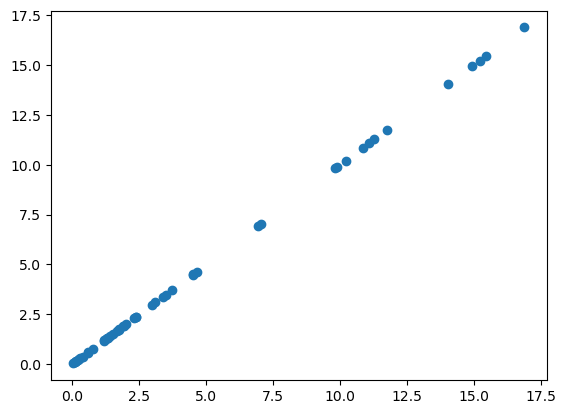

In [20]:
plt.scatter(lol.post_mean2,resL.post_mean2)

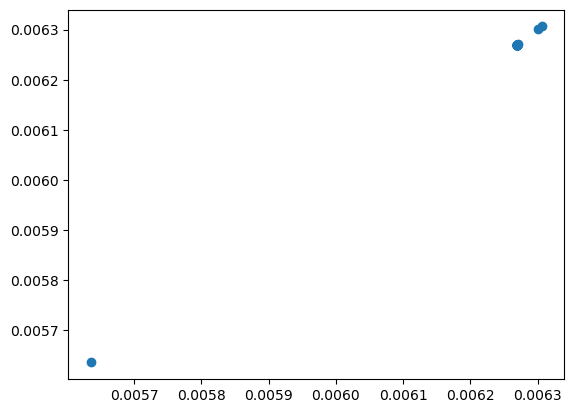

In [21]:
plt.scatter(lol.post_sd**2 ,resL.post_mean2-resL.post_mean**2)

In [22]:
k=0
Rk = mycebmf._partial_residual_masked(k)            # (N,P), zeros where missing
fk  = mycebmf.F[:, k]                                # (P,)
fk2 = mycebmf.F2[:, k]                               # (P,)

eps = 1e-12
denom_l = (fk2.view(1, -1) * mycebmf.mask).sum(dim=1).clamp_min(eps)     # (N,)
num_l   = (Rk @ fk)                                                   # (N,)
se_l    = torch.sqrt(1.0 / (mycebmf.tau * denom_l))


lhat = num_l / denom_l

resL = mycebmf.prior_L_fn(
            X=getattr(mycebmf, "X_l", None),
            betahat=lhat,
            sebetahat=se_l,
            model_param=mycebmf.model_state_L[k]
)
mycebmf.model_state_L[k] = resL.model_param
print(resL.post_mean)
mycebmf.L[:, k]  = resL.post_mean
mycebmf.L2[:, k] = resL.post_mean2

tensor([-1.0765, -0.1552, -2.1528, -1.7571, -1.5414, -1.2279, -0.7591, -1.1404,
        -1.0870, -3.9001, -3.3573, -0.2786, -3.1336, -2.6503, -1.1478, -1.3878,
        -1.3705, -0.7536, -3.1936, -2.6340, -1.1820, -1.4088, -1.5150, -1.5416,
        -0.3535, -0.2844, -2.1171, -1.2851, -3.7460, -1.8343, -3.9300, -1.3176,
        -3.3294, -1.9285, -1.3118, -3.8649, -0.4772, -0.5282, -2.1236, -1.1146,
        -1.8642, -1.7260, -4.1079, -0.3795, -3.2943, -0.8741, -3.1453, -3.4261,
        -0.6084, -0.4414], dtype=torch.float64)


In [23]:
denom_f = (lk2.view(-1, 1) * mycebmf.mask).sum(dim=0).clamp_min(eps)      # (P,)
num_f   = (Rk.T @ lk)                                                  # (P,)
se_f    = torch.sqrt(1.0 / (mycebmf.tau * denom_f))

In [24]:
mycebmf.mask

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [25]:
 
Rk = mycebmf._partial_residual_masked(k)            # (N,P), zeros where missing
fk  = mycebmf.F[:, k]                                # (P,)
fk2 = mycebmf.F2[:, k]                               # (P,)

eps = 1e-12
denom_l = (fk2.view(1, -1) * mycebmf.mask).sum(dim=1).clamp_min(eps)     # (N,)
num_l   = (Rk @ fk)                                                   # (N,)
se_l    = torch.sqrt(1.0 / (mycebmf.tau * denom_l))


lhat = num_l / denom_l

resL = mycebmf.prior_L_fn(
            X=getattr(mycebmf, "X_l", None),
            betahat=lhat,
            sebetahat=se_l,
            model_param=mycebmf.model_state_L[k]
)
mycebmf.model_state_L[k] = resL.model_param
print(resL.post_mean)
mycebmf.L[:, k]  = resL.post_mean
mycebmf.L2[:, k] = resL.post_mean2
mycebmf.kl_l[k]  = torch.as_tensor(resL.loss, device=mycebmf.device)
Rk = mycebmf._partial_residual_masked(k)            # recompute with updated L
lk  = mycebmf.L[:, k]                               # (N,)
lk2 = mycebmf.L2[:, k]                              # (N,)

if tau_map is None:
            denom_f = (lk2.view(-1, 1) * mycebmf.mask).sum(dim=0).clamp_min(eps)      # (P,)
            num_f   = (Rk.T @ lk)                                                  # (P,)
            se_f    = torch.sqrt(1.0 / (mycebmf.tau * denom_f))
else:
            denom_f = (tau_map * (lk2.view(-1, 1) * mycebmf.mask)).sum(dim=0).clamp_min(eps)  # (P,)
            num_f   = (tau_map * Rk).T @ lk                                                # (P,)
            se_f    = torch.sqrt(1.0 / denom_f)

fhat = num_f / denom_f 
resF = mycebmf.prior_F_fn(
            X=getattr(mycebmf, "X_f", None),
            betahat=fhat,
            sebetahat=se_f,
            model_param=mycebmf.model_state_F[k]
        )
mycebmf.model_state_F[k] = resF.model_param
print(resF.post_mean)
mycebmf.F[:, k]  = resF.post_mean
mycebmf.F2[:, k] = resF.post_mean2
mycebmf.kl_f[k]  = torch.as_tensor(resF.loss, device=mycebmf.device)


tensor([-1.0765, -0.1552, -2.1528, -1.7571, -1.5414, -1.2279, -0.7591, -1.1404,
        -1.0870, -3.9001, -3.3573, -0.2786, -3.1336, -2.6503, -1.1478, -1.3878,
        -1.3705, -0.7536, -3.1936, -2.6340, -1.1820, -1.4088, -1.5150, -1.5416,
        -0.3535, -0.2844, -2.1171, -1.2851, -3.7460, -1.8343, -3.9300, -1.3176,
        -3.3294, -1.9285, -1.3118, -3.8649, -0.4772, -0.5282, -2.1236, -1.1146,
        -1.8642, -1.7260, -4.1079, -0.3795, -3.2943, -0.8741, -3.1453, -3.4261,
        -0.6084, -0.4414], dtype=torch.float64)
tensor([-0.0346, -0.1409, -0.0033, -0.2040, -0.1176, -0.0072, -0.2310, -0.1752,
        -0.1537, -0.2228, -0.0544, -0.1940, -0.0261, -0.1711, -0.2372, -0.0781,
        -0.2404, -0.0280, -0.1942, -0.1146, -0.1228, -0.1836, -0.2128, -0.0841,
        -0.0971, -0.0334, -0.1129, -0.0906, -0.1750, -0.1760, -0.1829, -0.1479,
        -0.1141, -0.1198, -0.2098, -0.2042, -0.2252, -0.2121, -0.1984, -0.1542],
       dtype=torch.float64)


In [26]:
(lk2.view(-1, 1) * mycebmf.mask) .sum(dim=0)

tensor([226.3677, 226.3677, 226.3677, 226.3677, 226.3677, 226.3677, 226.3677,
        226.3677, 226.3677, 226.3677, 226.3677, 226.3677, 226.3677, 226.3677,
        226.3677, 226.3677, 226.3677, 226.3677, 226.3677, 226.3677, 226.3677,
        226.3677, 226.3677, 226.3677, 226.3677, 226.3677, 226.3677, 226.3677,
        226.3677, 226.3677, 226.3677, 226.3677, 226.3676, 226.3676, 226.3676,
        226.3676, 226.3676, 226.3676, 226.3676, 226.3676])

In [27]:
fhat/se_f

tensor([ -6.6120, -26.8076,  -1.1584, -38.8104, -22.3824,  -1.8171, -43.9332,
        -33.3225, -29.2461, -42.3693, -10.3744, -36.9072,  -4.9941, -32.5569,
        -45.1151, -14.8749, -45.7122,  -5.3558, -36.9439, -21.8050, -23.3644,
        -34.9283, -40.4778, -16.0264, -18.4916,  -6.3765, -21.4945, -17.2554,
        -33.3000, -33.4826, -34.7883, -28.1387, -21.7182, -22.8023, -39.9087,
        -38.8488, -42.8336, -40.3461, -37.7294, -29.3377])

In [28]:
se_l


tensor([0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792])

In [29]:

lolf=ebnm_point_laplace(
    x=fhat ,
    s=se_f ,    # a=exp(0)=1
    fix_par=[False,False, True] # optimize w only; fix a, mu
)

In [30]:
lol.mu

0.0

In [31]:
lol.w

AttributeError: 'EBNMLaplaceResult' object has no attribute 'w'

In [ ]:
# make sure this is the stable version we discussed
from cebmf_torch.torch_ebnm_point_exp import ebnm_point_exp
res = ebnm_point_exp(
    x=lhat.float(),
    s=se_l.float() 
) 
res.post_mean  # shrunk toward 0, not all zero


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [ ]:
from cebmf_torch.torch_ash import ash
chk = ash(lhat.float(), se_l.float(), prior="norm")
chk.post_mean  # finite; should be close to lhat for large SNR


tensor([-1.0784, -0.1156, -2.1531, -1.7580, -1.5426, -1.2296, -0.7614, -1.1422,
        -1.0889, -3.8980, -3.3559, -0.2798, -3.1325, -2.6499, -1.1496, -1.3893,
        -1.3720, -0.7560, -3.1924, -2.6336, -1.1837, -1.4102, -1.5162, -1.5428,
        -0.3564, -0.2859, -2.1175, -1.2867, -3.7441, -1.8351, -3.9278, -1.3192,
        -3.3281, -1.9292, -1.3134, -3.8627, -0.4800, -0.5309, -2.1240, -1.1164,
        -1.8650, -1.7269, -4.1054, -0.3824, -3.2929, -0.8763, -3.1442, -3.4246,
        -0.6110, -0.4442])

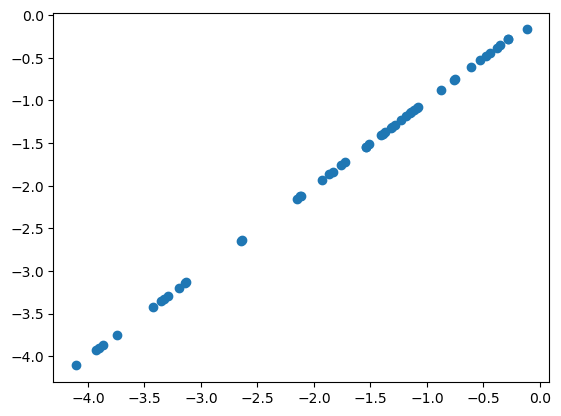

In [ ]:
plt.scatter( chk.post_mean, lol.post_mean)



In [ ]:

k=4
Rk = mycebmf._partial_residual_masked(k)            # (N,P), zeros where missing
fk  = mycebmf.F[:, k]                                # (P,)
fk2 = mycebmf.F2[:, k]                               # (P,)

eps = 1e-12
denom_l = (fk2.view(1, -1) * mycebmf.mask).sum(dim=1).clamp_min(eps)     # (N,)
num_l   = (Rk @ fk)                                                   # (N,)
se_l    = torch.sqrt(1.0 / (mycebmf.tau * denom_l))


lhat = num_l / denom_l

resL = mycebmf.prior_L_fn(
            X=getattr(mycebmf, "X_l", None),
            betahat=lhat,
            sebetahat=se_l,
            model_param=mycebmf.model_state_L[k]
)
mycebmf.model_state_L[k] = resL.model_param
mycebmf.L[:, k]  = resL.post_mean
mycebmf.L2[:, k] = resL.post_mean2
mycebmf.kl_l[k]  = torch.as_tensor(resL.loss, device=mycebmf.device)
se_l
resL.post_mean

tensor([-0.0226,  0.0505, -0.0251,  0.1828, -0.1567,  0.0110, -0.3370, -0.0044,
         0.0712, -0.0596, -0.0448,  0.2547, -0.0389, -0.1313, -0.0200,  0.0356,
        -0.1965, -0.1163, -0.0888,  0.1429,  0.0326, -0.0532,  0.0251, -0.0237,
         0.0247,  0.1337,  0.0305,  0.0491,  0.0300,  0.1066, -0.0835, -0.2645,
         0.0361,  0.0838,  0.0077,  0.0120,  0.0620,  0.0598, -0.0045,  0.0280,
         0.0456,  0.1544,  0.0578, -0.1150, -0.0277, -0.1523,  0.1149,  0.0121,
         0.1663,  0.0432], dtype=torch.float64)

In [ ]:

k=2
Rk = mycebmf._partial_residual_masked(k)            # (N,P), zeros where missing
fk  = mycebmf.F[:, k]                                # (P,)
fk2 = mycebmf.F2[:, k]                               # (P,)

eps = 1e-12
denom_l = (fk2.view(1, -1) * mycebmf.mask).sum(dim=1).clamp_min(eps)     # (N,)
num_l   = (Rk @ fk)                                                   # (N,)
se_l    = torch.sqrt(1.0 / (mycebmf.tau * denom_l))


lhat = num_l / denom_l

resL = mycebmf.prior_L_fn(
            X=getattr(mycebmf, "X_l", None),
            betahat=lhat,
            sebetahat=se_l,
            model_param=mycebmf.model_state_L[k]
)
mycebmf.model_state_L[k] = resL.model_param
mycebmf.L[:, k]  = resL.post_mean
mycebmf.L2[:, k] = resL.post_mean2
mycebmf.kl_l[k]  = torch.as_tensor(resL.loss, device=mycebmf.device)
se_l
resL.post_mean

tensor([ 0.1068,  0.0980, -0.2368,  0.1943,  0.0620, -0.0908,  0.0014,  0.1286,
         0.0127,  0.0065, -0.0906,  0.1161,  0.0786, -0.0489,  0.0723,  0.0782,
         0.1107,  0.0751, -0.0848,  0.0736, -0.2393, -0.1654, -0.1627,  0.0317,
        -0.0285, -0.0685,  0.0622,  0.0150,  0.2281,  0.0139, -0.0656,  0.2216,
        -0.1260, -0.1321, -0.0561,  0.2201, -0.2013, -0.0437, -0.0499, -0.0827,
         0.0081, -0.0349,  0.0280, -0.1552, -0.1280,  0.1366, -0.0451,  0.0025,
         0.1011,  0.2737], dtype=torch.float64)

In [ ]:
lhat
se_l

tensor([0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792])

In [ ]:
from cebmf_torch.torch_ebnm_point_laplace import ebnm_point_laplace
lol= ebnm_point_laplace(lhat , se_l) 
lol.post_mean


tensor([ 0.1068,  0.0980, -0.2369,  0.1943,  0.0620, -0.0908,  0.0014,  0.1286,
         0.0127,  0.0065, -0.0907,  0.1161,  0.0786, -0.0489,  0.0724,  0.0782,
         0.1107,  0.0751, -0.0848,  0.0736, -0.2393, -0.1655, -0.1627,  0.0317,
        -0.0285, -0.0685,  0.0623,  0.0150,  0.2281,  0.0139, -0.0656,  0.2216,
        -0.1261, -0.1321, -0.0562,  0.2201, -0.2013, -0.0437, -0.0499, -0.0827,
         0.0081, -0.0349,  0.0280, -0.1552, -0.1280,  0.1367, -0.0451,  0.0025,
         0.1011,  0.2737], dtype=torch.float64)

In [ ]:
se_l

tensor([0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792, 0.0792,
        0.0792, 0.0792, 0.0792, 0.0792, 0.0792])

In [ ]:
lhat

tensor([ 0.1571,  0.1465, -0.2942,  0.2512,  0.0996, -0.1377,  0.0024,  0.1820,
         0.0220,  0.0113, -0.1375,  0.1678,  0.1221, -0.0805,  0.1139,  0.1217,
         0.1616,  0.1175, -0.1302,  0.1156, -0.2967, -0.2215, -0.2186,  0.0538,
        -0.0485, -0.1087,  0.1000,  0.0259,  0.2854,  0.0241, -0.1046,  0.2789,
        -0.1791, -0.1858, -0.0913,  0.2774, -0.2584, -0.0726, -0.0821, -0.1275,
         0.0141, -0.0588,  0.0477, -0.2107, -0.1813,  0.1908, -0.0748,  0.0044,
         0.1503,  0.3311])

In [ ]:
lol= ebnm_point_laplace(lhat , se_l  ) 
lol.post_mean


tensor([ 0.1068,  0.0980, -0.2369,  0.1943,  0.0620, -0.0908,  0.0014,  0.1286,
         0.0127,  0.0065, -0.0907,  0.1161,  0.0786, -0.0489,  0.0724,  0.0782,
         0.1107,  0.0751, -0.0848,  0.0736, -0.2393, -0.1655, -0.1627,  0.0317,
        -0.0285, -0.0685,  0.0623,  0.0150,  0.2281,  0.0139, -0.0656,  0.2216,
        -0.1261, -0.1321, -0.0562,  0.2201, -0.2013, -0.0437, -0.0499, -0.0827,
         0.0081, -0.0349,  0.0280, -0.1552, -0.1280,  0.1367, -0.0451,  0.0025,
         0.1011,  0.2737], dtype=torch.float64)

In [ ]:
lol.w

0.9999071359634399

In [ ]:
ebnm_point_laplace(
    x=lhat.double(),
    s=se_l.double(),    # a=exp(0)=1
    fix_par=[False,False, True] # optimize w only; fix a, mu
)

EBNMLaplaceResult(post_mean=tensor([ 0.1068,  0.0980, -0.2368,  0.1943,  0.0620, -0.0908,  0.0014,  0.1286,
         0.0127,  0.0065, -0.0906,  0.1161,  0.0786, -0.0489,  0.0723,  0.0782,
         0.1107,  0.0751, -0.0848,  0.0736, -0.2393, -0.1654, -0.1627,  0.0317,
        -0.0285, -0.0685,  0.0622,  0.0150,  0.2281,  0.0139, -0.0656,  0.2216,
        -0.1260, -0.1321, -0.0561,  0.2201, -0.2013, -0.0437, -0.0499, -0.0827,
         0.0081, -0.0349,  0.0280, -0.1552, -0.1280,  0.1366, -0.0451,  0.0025,
         0.1011,  0.2737], dtype=torch.float64), post_mean2=tensor([0.0167, 0.0148, 0.0620, 0.0439, 0.0083, 0.0068, 0.0036, 0.0222, 0.0038,
        0.0037, 0.0067, 0.0189, 0.0110, 0.0030, 0.0099, 0.0109, 0.0176, 0.0104,
        0.0055, 0.0101, 0.0632, 0.0309, 0.0299, 0.0049, 0.0046, 0.0033, 0.0083,
        0.0039, 0.0582, 0.0039, 0.0030, 0.0553, 0.0167, 0.0187, 0.0028, 0.0547,
        0.0457, 0.0035, 0.0030, 0.0052, 0.0037, 0.0049, 0.0046, 0.0270, 0.0173,
        0.0244, 0.0034, 0.0036, 

In [ ]:
ebnm_point_laplace(
    x=lhat.double(),
    s=se_l.double(),
    par_init=[0.0, 2.0, 0.0],   # a=exp(0)=1
    fix_par=[False,False, True] # optimize w only; fix a, mu
)

EBNMLaplaceResult(post_mean=tensor([ 0.1068,  0.0980, -0.2368,  0.1943,  0.0620, -0.0908,  0.0014,  0.1286,
         0.0127,  0.0065, -0.0906,  0.1161,  0.0786, -0.0489,  0.0723,  0.0782,
         0.1107,  0.0751, -0.0848,  0.0736, -0.2393, -0.1654, -0.1627,  0.0317,
        -0.0285, -0.0685,  0.0622,  0.0150,  0.2281,  0.0139, -0.0656,  0.2216,
        -0.1260, -0.1321, -0.0561,  0.2201, -0.2013, -0.0437, -0.0499, -0.0827,
         0.0081, -0.0349,  0.0280, -0.1552, -0.1280,  0.1366, -0.0451,  0.0025,
         0.1011,  0.2737], dtype=torch.float64), post_mean2=tensor([0.0167, 0.0148, 0.0620, 0.0439, 0.0083, 0.0068, 0.0036, 0.0222, 0.0038,
        0.0037, 0.0067, 0.0189, 0.0110, 0.0030, 0.0099, 0.0109, 0.0176, 0.0104,
        0.0055, 0.0101, 0.0632, 0.0309, 0.0299, 0.0049, 0.0046, 0.0033, 0.0083,
        0.0039, 0.0582, 0.0039, 0.0030, 0.0553, 0.0167, 0.0187, 0.0028, 0.0547,
        0.0457, 0.0035, 0.0030, 0.0052, 0.0037, 0.0049, 0.0046, 0.0270, 0.0173,
        0.0244, 0.0034, 0.0036, 